# Auto-Encoding Variational Bayes

## 0. Paper

### Info
* TItle : Auto-Encoding Variational Bayes
* Author : Diederik P Kingma, Max Welling
* Link : https://arxiv.org/pdf/1312.6114.pdf

### Summary
* Loss : Reconstruction loss + KL Divergence
* Sampling : Reparameterization trick

### Features
* dataset : Cifar10

### Reference
* https://keras.io/examples/generative/vae/

## 1. Setting

In [1]:
# Libraries
import os
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

In [217]:
# Hyperparameters
CFG = {
    'latent_dim' : 128,
    'batch_size' : 128,
    'epoch_size' : 100,
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
}

## 2. Data

In [218]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [219]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## 3. Model

In [220]:
class SamplingLayer(tf.keras.layers.Layer):
    def call(self, x):
        z_mean, z_logvar = x
        eps = tf.random.normal(tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_logvar) * eps

def build_encoder():
    inputs = tf.keras.layers.Input((32, 32, 3))
    x = tf.keras.layers.Conv2D(64, 4, 2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(128, 4, 2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 4, 2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    z_mean = tf.keras.layers.Dense(CFG['latent_dim'])(x)
    z_logvar = tf.keras.layers.Dense(CFG['latent_dim'])(x)
    z = SamplingLayer()([z_mean, z_logvar])

    encoder = tf.keras.Model(inputs, [z, z_mean, z_logvar])
    return encoder

def build_decoder():
    inputs = tf.keras.layers.Input((CFG['latent_dim'],))
    x = tf.keras.layers.Dense(4*4*256, activation='relu')(inputs)
    x = tf.keras.layers.Reshape((4,4,256))(x)
    x = tf.keras.layers.Conv2DTranspose(256, 4, 2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, 4, 2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, 4, 2, padding='same', activation='relu')(x)
    outputs = tf.keras.layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)

    decoder = tf.keras.Model(inputs, outputs)
    return decoder

In [221]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = build_encoder()
        self.decoder = build_decoder()

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z, z_mean, z_logvar = self.encoder(data)
            recon = self.decoder(z)
            
            recon_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, recon))
            recon_loss *= 32 * 32
            kl_loss = (tf.square(z_mean) + tf.exp(z_logvar) - z_logvar - 1) * 0.5
            kl_loss = tf.reduce_mean(kl_loss)
            loss = recon_loss + kl_loss
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            'loss': loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

In [222]:
model = Model()
model.compile(
    optimizer = tf.keras.optimizers.Adam()
)

In [223]:
model.encoder.summary()

Model: "functional_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 16, 16, 64)   3136        input_48[0][0]                   
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 8, 8, 128)    131200      conv2d_53[0][0]                  
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 4, 4, 256)    524544      conv2d_54[0][0]                  
______________________________________________________________________________________

In [224]:
model.decoder.summary()

Model: "functional_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_70 (Dense)             (None, 4096)              528384    
_________________________________________________________________
reshape_22 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_71 (Conv2DT (None, 8, 8, 256)         1048832   
_________________________________________________________________
conv2d_transpose_72 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
conv2d_transpose_73 (Conv2DT (None, 32, 32, 64)        131136    
_________________________________________________________________
conv2d_transpose_74 (Conv2DT (None, 32, 32, 3)       

## 4. Train

In [225]:
model.fit(
    x_train,
    batch_size = CFG['batch_size'],
    epochs = CFG['epoch_size']
)

Epoch 1/100
391/391 [==============================] - 5s 13ms/step - loss: 630.8010 - recon_loss: 629.5229 - kl_loss: 1.2781
Epoch 2/100
391/391 [==============================] - 5s 13ms/step - loss: 593.6240 - recon_loss: 591.6865 - kl_loss: 1.9374
Epoch 3/100
391/391 [==============================] - 5s 13ms/step - loss: 586.9643 - recon_loss: 584.8796 - kl_loss: 2.0847
Epoch 4/100
391/391 [==============================] - 5s 13ms/step - loss: 583.0316 - recon_loss: 580.8719 - kl_loss: 2.1596
Epoch 5/100
391/391 [==============================] - 5s 13ms/step - loss: 581.1329 - recon_loss: 578.9250 - kl_loss: 2.2079
Epoch 6/100
391/391 [==============================] - 5s 13ms/step - loss: 579.2967 - recon_loss: 577.0705 - kl_loss: 2.2261
Epoch 7/100
391/391 [==============================] - 5s 13ms/step - loss: 578.2572 - recon_loss: 576.0154 - kl_loss: 2.2418
Epoch 8/100
391/391 [==============================] - 5s 13ms/step - loss: 577.6437 - recon_loss: 575.3876 - kl_loss:

## 5. Test

In [226]:
def plot(num_img):
    figure = np.zeros((32*num_img, 32*num_img, 3)).astype(np.int32)
    for i in range(num_img):
        for j in range(num_img):
            z = np.random.uniform(-1, 1, size=CFG['latent_dim'])[None,:]
            pred = model.decoder(z)[0]
            pred = (pred.numpy() * 255.0).astype(np.int32)
            figure[i*32 : (i+1)*32, j*32 : (j+1)*32] = pred
    
    plt.figure(figsize=(11, 11))
    plt.imshow(figure)
    plt.show()

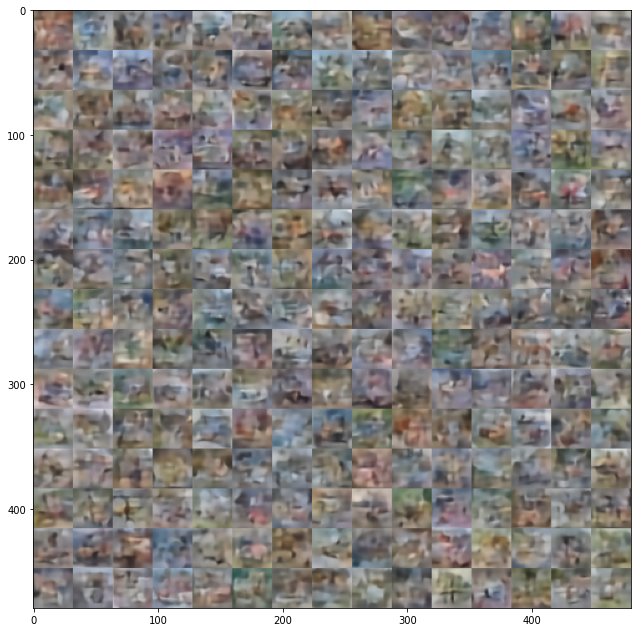

In [227]:
plot(15)